# Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

# Evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay

# SHAP
import shap

# Load dataset

In [2]:
df = pd.read_csv("D:\\TakeHomeTest\\DS\\Dataset\\Food_Delivery_Times.csv")

# Melihat 5 data teratas
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


# Data Understanding

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Order_ID                1000 non-null   int64  
 1   Distance_km             1000 non-null   float64
 2   Weather                 970 non-null    object 
 3   Traffic_Level           970 non-null    object 
 4   Time_of_Day             970 non-null    object 
 5   Vehicle_Type            1000 non-null   object 
 6   Preparation_Time_min    1000 non-null   int64  
 7   Courier_Experience_yrs  970 non-null    float64
 8   Delivery_Time_min       1000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 70.4+ KB


,Order_ID,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
count,1000.000000,1000.000000,1000.000000,970.000000,1000.000000
mean,500.500000,10.059970,16.982000,4.579381,56.732000
std,288.819436,5.696656,7.204553,2.914394,22.070915
min,1.000000,0.590000,5.000000,0.000000,8.000000
25%,250.750000,5.105000,11.000000,2.000000,41.000000
50%,500.500000,10.190000,17.000000,5.000000,55.500000
75%,750.250000,15.017500,23.000000,7.000000,71.000000
max,1000.000000,19.990000,29.000000,9.000000,153.000000


**Feature Groups**
- **Order Characteristics:** Distance_km, Vehicle_Type
- **Environmental Factors:** Traffic_Level, Weather_Condition
- **Courier Factors:** Courier_Experience_yrs
- **Time Factors:** Order_Hour

## Missing Values

In [4]:
df.isnull().sum()

Order_ID                   0
Distance_km                0
Weather                   30
Traffic_Level             30
Time_of_Day               30
Vehicle_Type               0
Preparation_Time_min       0
Courier_Experience_yrs    30
Delivery_Time_min          0
dtype: int64

# Exploratory Data Analysis (EDA)

## 4.1 Target Variable Distribution

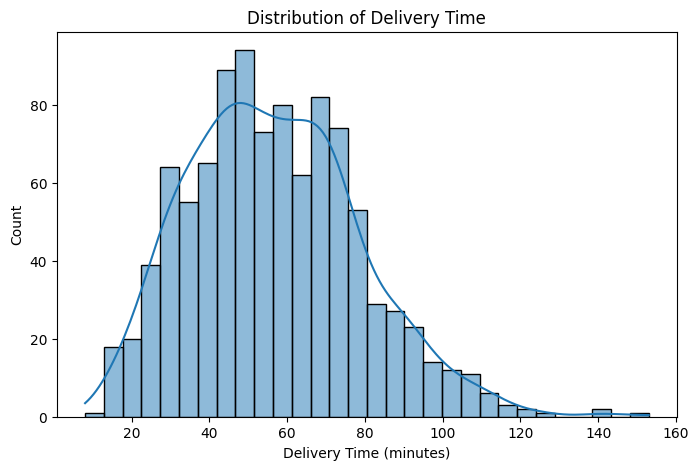

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df["Delivery_Time_min"], bins=30, kde=True)
plt.title("Distribution of Delivery Time")
plt.xlabel("Delivery Time (minutes)")
plt.show()

**Bentuk Distribusi:**

- Grafik ini menunjukkan distribusi yang menceng ke kanan (right-skewed) atau memiliki positive skew. Artinya, sebagian besar pengiriman selesai dalam waktu singkat hingga menengah, tetapi ada beberapa pengiriman yang memakan waktu sangat lama.

**Puncak (Modus):**

- Konsentrasi pengiriman tertinggi berada di rentang waktu sekitar 45 hingga 50 menit. Ini adalah waktu pengiriman yang paling sering terjadi.

**Rentang Waktu (Range):** 

- Waktu pengiriman bervariasi dari yang tercepat sekitar 10-15 menit hingga yang paling lama mencapai lebih dari 150 menit (meskipun frekuensinya sangat kecil di atas 120 menit).

## 4.2 Distance vs Delivery Time

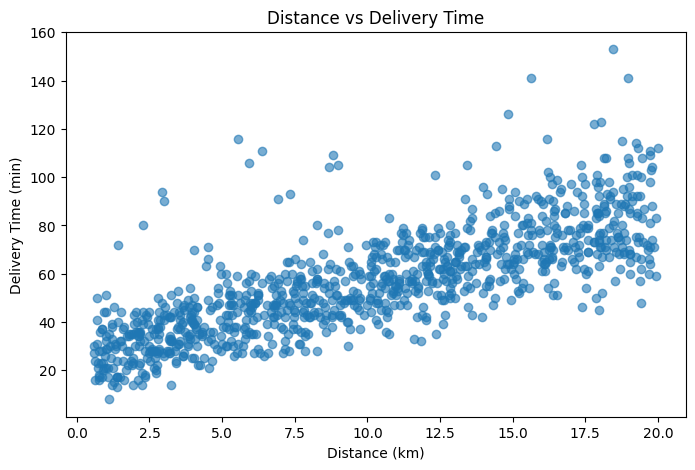

In [6]:
plt.figure(figsize=(8,5))
plt.scatter(df["Distance_km"], df["Delivery_Time_min"], alpha=0.6)
plt.xlabel("Distance (km)")
plt.ylabel("Delivery Time (min)")
plt.title("Distance vs Delivery Time")
plt.show()

**Hubungan Korelasi**

- **Korelasi Positif:** Terdapat hubungan linear positif yang jelas antara kedua variabel. Artinya, secara umum, semakin jauh jarak pengiriman (km), maka semakin lama waktu yang dibutuhkan (menit) untuk sampai ke tujuan.

**Sebaran Data dan Variabilitas**

- **Rentang Jarak:** Data mencakup pengiriman dari jarak sangat dekat (sekitar 0.5 km) hingga jarak jauh (20 km).

- **Variabilitas Waktu:** Untuk jarak yang sama, waktu pengiriman bisa bervariasi. Misalnya, pada jarak 10 km, waktu pengiriman berkisar antara sekitar 40 menit hingga 80 menit. Variasi ini kemungkinan disebabkan oleh faktor lain seperti kemacetan, waktu persiapan makanan, atau cuaca.

- **Peningkatan Varians:** Terlihat bahwa sebaran titik menjadi sedikit lebih lebar (lebih tersebar) saat jarak bertambah (di atas 15 km). Ini menandakan bahwa ketidakpastian waktu pengiriman meningkat pada jarak yang lebih jauh.

## 4.3 Traffic Level vs Delivery Time

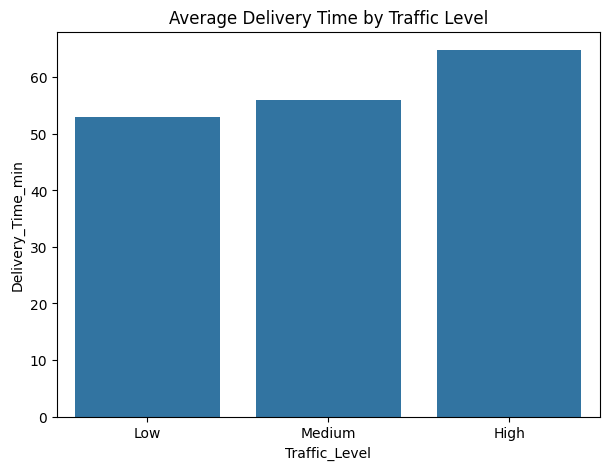

In [7]:
plt.figure(figsize=(7,5))
sns.barplot(x="Traffic_Level", y="Delivery_Time_min", data=df, errorbar=None)
plt.title("Average Delivery Time by Traffic Level")
plt.show()

Gabungan kedua data ini menunjukkan bahwa meskipun **jarak adalah faktor utama** penentu waktu pengiriman, **kondisi lalu lintas merupakan variabel krusial** yang menyebabkan fluktuasi waktu.

Pengiriman pada kondisi lalu lintas tinggi (High) rata-rata memakan waktu sekitar 12 menit lebih lama dibandingkan pada kondisi lalu lintas rendah (Low), terlepas dari berapa pun jarak tempuhnya.

## 4.4 Vehicle Type vs Delivery Time

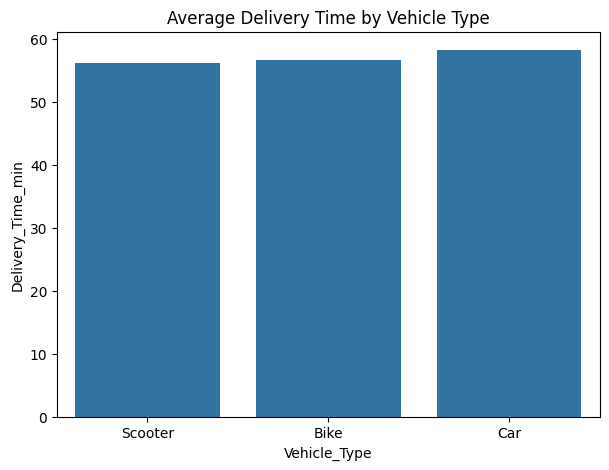

In [8]:
plt.figure(figsize=(7,5))
sns.barplot(x="Vehicle_Type", y="Delivery_Time_min", data=df, errorbar=None)
plt.title("Average Delivery Time by Vehicle Type")
plt.show()

- **Jarak:** Semakin jauh jarak, waktu pengiriman pasti meningkat secara linear.
- **Lalu Lintas:** Faktor penghambat terbesar; kondisi macet (High) menambah waktu rata-rata hingga 12 menit dibandingkan lancar (Low).
- **Kendaraan:** Pengaruhnya sangat kecil; Scooter tercepat (~56 menit), sedangkan Mobil terlambat (+-59 menit).
- **Ketidakpastian:** Jarak jauh (>15 km) memiliki risiko keterlambatan yang jauh lebih tidak terprediksi.

## 4.5 Courier Experience vs Delivery Time

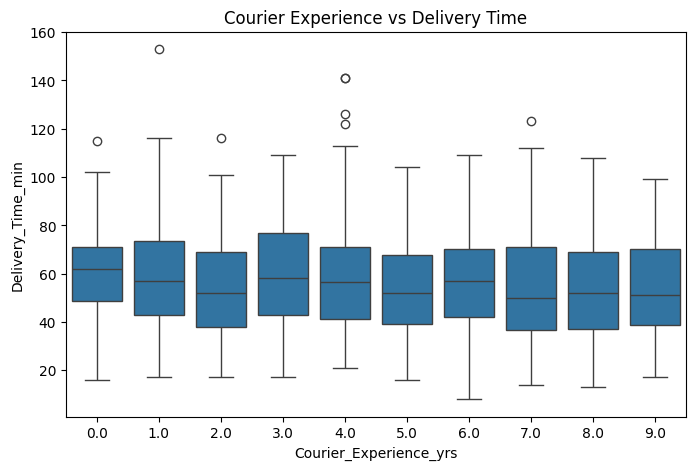

In [9]:
plt.figure(figsize=(8,5))
sns.boxplot(x="Courier_Experience_yrs", y="Delivery_Time_min", data=df)
plt.title("Courier Experience vs Delivery Time")
plt.show()

**Pengalaman bertahun-tahun sebagai kurir dalam data ini tidak menjamin waktu pengiriman yang lebih cepat.** Faktor-faktor lain kemungkinan besar memainkan peran yang lebih dominan dalam menentukan durasi pengiriman.

# Feature Engineering

**Purpose**

Feature engineering is applied to capture **non-linear delivery behavior** and **operational realities** that are not directly represented in raw features.

## Distance Category (Non-linear Effect)

In [10]:
df['Distance_Category'] = pd.cut(
df['Distance_km'],
bins=[0,3,7,12,20],
labels=['Very_Near','Near','Medium','Far']
)

Saya mengkategorikan jarak untuk mengurangi noise pada fitur numerik, menangkap hubungan non-linear dengan target, serta membuat model lebih stabil dan mudah diinterpretasikan. Dengan binning, model fokus pada perbedaan jarak yang benar-benar bermakna secara perilaku, bukan variasi kecil yang tidak signifikan.

Jarak dikategorikan agar mencerminkan persepsi pelanggan (dekat–jauh), sehingga dampaknya terhadap perilaku seperti churn atau konversi lebih mudah dianalisis dan dijadikan dasar keputusan bisnis.

## Peak Hour Indicator

In [11]:
peak_hours = ['Morning','Evening']
df['Is_Peak_Hour'] = df['Time_of_Day'].isin(peak_hours).astype(int)

Mengubah Time_of_Day menjadi fitur biner Is_Peak_Hour menyederhanakan pola waktu yang kompleks, mengurangi noise kategori, dan membantu model menangkap perbedaan perilaku yang signifikan antara jam sibuk dan non-sibuk secara lebih stabil.

Kategori jam sibuk merepresentasikan periode dengan permintaan dan kepadatan tinggi, sehingga dampaknya terhadap perilaku pelanggan (seperti churn, keterlambatan, atau pembatalan) lebih relevan untuk pengambilan keputusan operasional.

## Courier Experience Level

In [12]:
df['Experience_Level'] = pd.cut(
df['Courier_Experience_yrs'],
bins=[-1,2,5,10],
labels=['Junior','Mid','Senior']
)

Pengalaman kurir dikategorikan untuk mengurangi noise pada data numerik, menangkap efek non-linear antara pengalaman dan performa, serta membuat model lebih stabil dan lebih mudah diinterpretasikan.

Kategori Junior–Mid–Senior merepresentasikan tingkat kompetensi operasional kurir, sehingga perbedaannya lebih relevan untuk analisis risiko, kualitas layanan, dan pengambilan keputusan terkait pelatihan atau penugasan.

## Distance × Traffic Interaction

In [13]:
traffic_weight = {'Low':1.0,'Medium':1.3,'High':1.6}
df['Distance_x_Traffic'] = df['Distance_km'] * df['Traffic_Level'].map(traffic_weight)

Fitur Distance_x_Traffic dibuat untuk menangkap efek interaksi antara jarak dan tingkat kemacetan, sehingga model dapat memahami bahwa dampak jarak terhadap target berbeda pada kondisi lalu lintas yang berbeda.

Secara bisnis, jarak yang sama memiliki beban operasional dan risiko yang lebih tinggi saat lalu lintas padat, sehingga fitur ini merepresentasikan effective distance yang lebih realistis terhadap waktu tempuh, biaya, dan kualitas layanan.

## Preparation Time × Peak Hour

In [14]:
df['Prep_x_Peak'] = df['Preparation_Time_min'] * df['Is_Peak_Hour']

Fitur Prep_x_Peak dibuat untuk menangkap efek interaksi, di mana dampak waktu persiapan terhadap target menjadi lebih signifikan saat jam sibuk dibandingkan jam normal.

Secara bisnis, keterlambatan akibat waktu persiapan yang lama jauh lebih berisiko pada jam sibuk karena tekanan permintaan dan keterbatasan kapasitas, sehingga kombinasi ini lebih relevan dibanding melihat waktu persiapan secara terpisah.

**Feature Engineering Summary**

These engineered features allow the model to better capture congestion risk, courier skill segmentation, and compounding delay effects.

In [15]:
df.head()

,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min,Distance_Category,Is_Peak_Hour,Experience_Level,Distance_x_Traffic,Prep_x_Peak
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43,Medium,0,Junior,7.930,0
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84,Far,1,Junior,21.346,20
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59,Medium,0,Junior,9.520,0
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37,Medium,0,Junior,9.672,0
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68,Far,1,Mid,19.030,16


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Order_ID                1000 non-null   int64   
 1   Distance_km             1000 non-null   float64 
 2   Weather                 970 non-null    object  
 3   Traffic_Level           970 non-null    object  
 4   Time_of_Day             970 non-null    object  
 5   Vehicle_Type            1000 non-null   object  
 6   Preparation_Time_min    1000 non-null   int64   
 7   Courier_Experience_yrs  970 non-null    float64 
 8   Delivery_Time_min       1000 non-null   int64   
 9   Distance_Category       1000 non-null   category
 10  Is_Peak_Hour            1000 non-null   int64   
 11  Experience_Level        970 non-null    category
 12  Distance_x_Traffic      970 non-null    float64 
 13  Prep_x_Peak             1000 non-null   int64   
dtypes: category(2), float64(3

# 5. Data Preprocessing

## 5.1 Drop Irrelevant Columns

In [17]:
df = df.drop(columns=["Order_ID"])

## 5.2 Split Feature & Target

In [18]:
X = df.drop("Delivery_Time_min", axis=1)
y = df["Delivery_Time_min"]

## 5.3 Train-Test Split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

## 5.4 Handle Missing Values

In [20]:
num_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

for col in num_cols:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)
    X_test[col] = X_test[col].fillna(median_val)

In [21]:
cat_cols = X_train.select_dtypes(include=["object"]).columns

for col in cat_cols:
    mode_val = X_train[col].mode()[0]
    X_train[col] = X_train[col].fillna(mode_val)
    X_test[col] = X_test[col].fillna(mode_val)

In [22]:
# save statistik
num_medians = X_train[num_cols].median().to_dict()
cat_modes = {col: X_train[col].mode()[0] for col in cat_cols}

## 5.5 One-Hot Encoding

In [23]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_test_cat = encoder.transform(X_test[cat_cols])

X_train_cat = pd.DataFrame(
    X_train_cat,
    columns=encoder.get_feature_names_out(cat_cols),
    index=X_train.index
)

X_test_cat = pd.DataFrame(
    X_test_cat,
    columns=encoder.get_feature_names_out(cat_cols),
    index=X_test.index
)

## 5.6 Gabungkan Data

In [24]:
X_train_base = pd.concat([X_train[num_cols], X_train_cat], axis=1)
X_test_base  = pd.concat([X_test[num_cols], X_test_cat], axis=1)

## 5.7 Feature Scaling

In [25]:
# untuk Linear Regression
scaler = StandardScaler()

X_train_scaled = X_train_base.copy()
X_test_scaled  = X_test_base.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train_scaled[num_cols])
X_test_scaled[num_cols]  = scaler.transform(X_test_scaled[num_cols])

# Baseline Model — Linear Regression

In [26]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

y_pred_lr = lr.predict(X_test_scaled)

print("Linear Regression")
print("MAE :", mean_absolute_error(y_test, y_pred_lr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("R2  :", r2_score(y_test, y_pred_lr))

Linear Regression
MAE : 6.2723974155818505
RMSE: 9.318445569302375
R2  : 0.8265757032730467


# Gradient Boosting

In [27]:
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train_base, y_train)

y_pred_gbr = gbr.predict(X_test_base)

print("\nGradient Boosting")
print("MAE :", mean_absolute_error(y_test, y_pred_gbr))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gbr)))
print("R2  :", r2_score(y_test, y_pred_gbr))


Gradient Boosting
MAE : 6.43743312672247
RMSE: 9.605023736956678
R2  : 0.8157447456129058


# XGBoost (Baseline)

In [28]:
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42
)

xgb.fit(X_train_base, y_train)
y_pred_xgb = xgb.predict(X_test_base)

print("\nXGBoost")
print("MAE :", mean_absolute_error(y_test, y_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("R2  :", r2_score(y_test, y_pred_xgb))


XGBoost
MAE : 7.835000038146973
RMSE: 10.9426982624795
R2  : 0.7608492374420166


# Hyperparameter Tuning (Gradient Boosting)

In [32]:
param_grid_gb = {
    "n_estimators": [150, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 4]
}

gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid_gb,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

gb_grid.fit(X_train_base, y_train)
best_gb = gb_grid.best_estimator_

In [33]:
y_pred_gb = best_gb.predict(X_test_base)

print("\nBest Gradient Boosting (Tuned)")
print("MAE :", mean_absolute_error(y_test, y_pred_gb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gb)))
print("R2  :", r2_score(y_test, y_pred_gb))


Best Gradient Boosting (Tuned)
MAE : 6.468396643078359
RMSE: 9.636175337738573
R2  : 0.814547631645426


# Hyperparameter Tuning (XGBoost)

In [29]:
param_grid = {
    "n_estimators": [150, 200],
    "learning_rate": [0.05, 0.1],
    "max_depth": [3, 4]
}

xgb_grid = GridSearchCV(
    XGBRegressor(objective="reg:squarederror", random_state=42),
    param_grid,
    cv=5,
    scoring="neg_mean_absolute_error",
    n_jobs=-1
)

xgb_grid.fit(X_train_base, y_train)
best_xgb = xgb_grid.best_estimator_

In [30]:
y_pred_best = best_xgb.predict(X_test_base)

print("\nBest XGBoost (Tuned)")
print("MAE :", mean_absolute_error(y_test, y_pred_best))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_best)))
print("R2  :", r2_score(y_test, y_pred_best))


Best XGBoost (Tuned)
MAE : 6.382791996002197
RMSE: 9.570050618228162
R2  : 0.8170840740203857


Saya memilih XGBoost tuned karena memberikan performa yang kompetitif sekaligus mampu menangkap hubungan non-linear dan interaksi fitur yang tidak dapat ditangani Linear Regression.

**Alasan memilih XGBoost:**
- Performa kompetitif dan stabil setelah tuning (MAE & RMSE mendekati model terbaik).
- Mampu menangkap hubungan non-linear dan interaksi fitur yang tidak bisa ditangani Linear Regression.
- Lebih robust terhadap outlier dan distribusi data yang tidak ideal.
- Scalable dan production-ready, cocok untuk data yang berkembang.
- Tetap interpretatif dengan SHAP sehingga insight bisnis dapat dijelaskan.

# Feature Importance (Best Model)

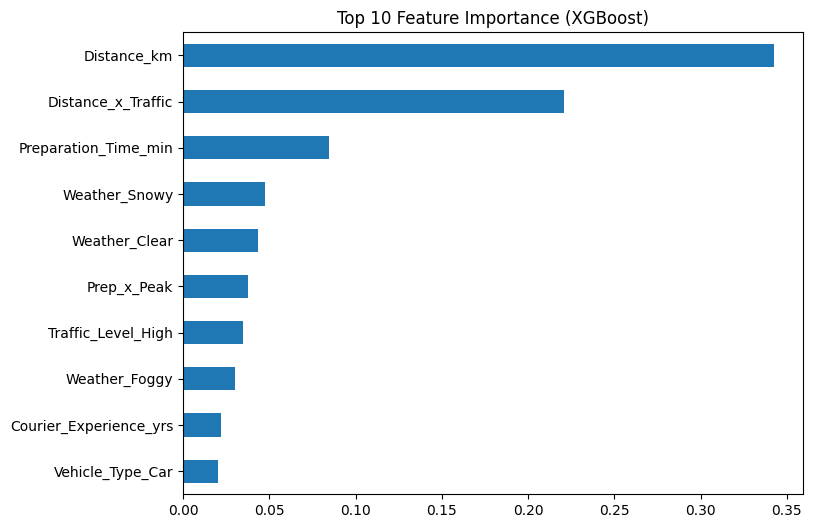

Distance_km               0.342301
Distance_x_Traffic        0.220910
Preparation_Time_min      0.084767
Weather_Snowy             0.047430
Weather_Clear             0.043688
Prep_x_Peak               0.037803
Traffic_Level_High        0.034849
Weather_Foggy             0.030358
Courier_Experience_yrs    0.021913
Vehicle_Type_Car          0.020192
Traffic_Level_Low         0.019516
Time_of_Day_Evening       0.017537
Weather_Windy             0.017180
Time_of_Day_Afternoon     0.014305
Vehicle_Type_Bike         0.012554
Weather_Rainy             0.011154
Traffic_Level_Medium      0.009654
Time_of_Day_Morning       0.007111
Time_of_Day_Night         0.006779
Is_Peak_Hour              0.000000
Vehicle_Type_Scooter      0.000000
dtype: float32


In [31]:
importances = pd.Series(
    best_xgb.feature_importances_,
    index=X_train_base.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances.head(10).plot(kind="barh")
plt.title("Top 10 Feature Importance (XGBoost)")
plt.gca().invert_yaxis()
plt.show()
print(importances)

**Interpretasi:**

- **Jarak adalah faktor utama:** Distance_km dan Distance_x_Traffic paling dominan → semakin jauh dan semakin macet, dampak ke target makin besar.
- **Kemacetan memperkuat efek jarak:** kombinasi jarak × traffic lebih penting dibanding traffic saja.
- **Waktu persiapan signifikan**, terutama saat jam sibuk (Prep_x_Peak) → bottleneck operasional.
- **Cuaca buruk meningkatkan risiko** (snowy, foggy, windy, rainy), meski kontribusi individual lebih kecil.
- **Traffic** lebih berpengaruh daripada jam dalam sehari (morning/evening).
- **Pengalaman kurir & jenis kendaraan berpengaruh sekunder**, membantu tapi bukan penentu utama.
- **Fitur nol importance masuk akal:** Is_Peak_Hour tertangkap lewat interaksi, Vehicle_Type_Scooter tidak memberi sinyal tambahan.

# SHAP Analysis (Best Model)

## SHAP Explainer

In [45]:
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_base)

## SHAP Summary Plot

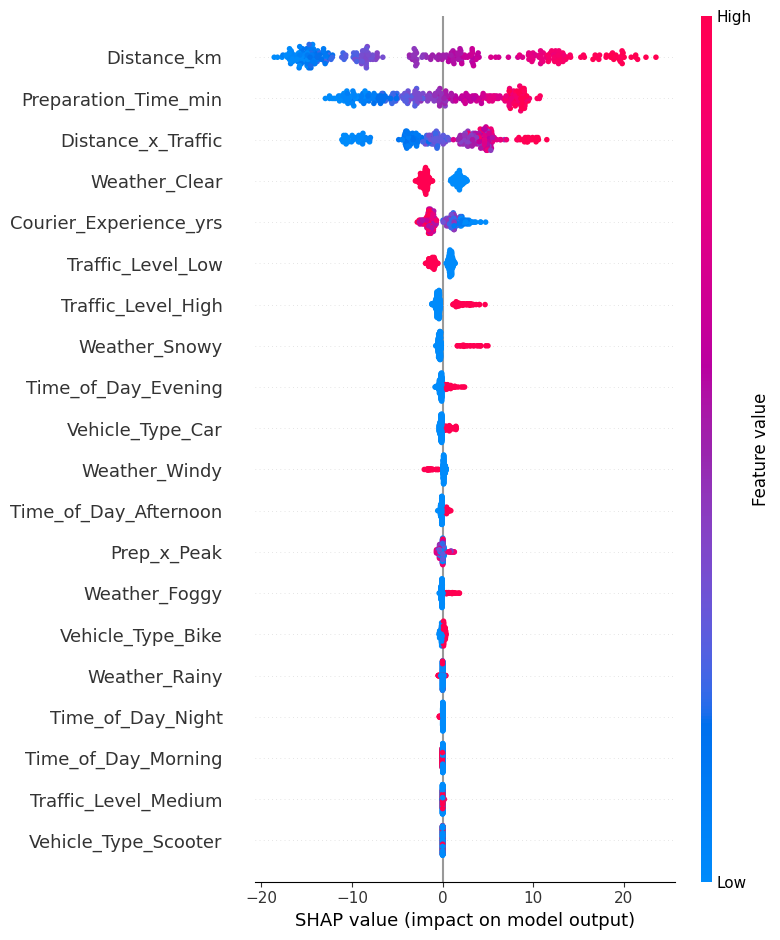

In [46]:
shap.summary_plot(shap_values, X_test_base)

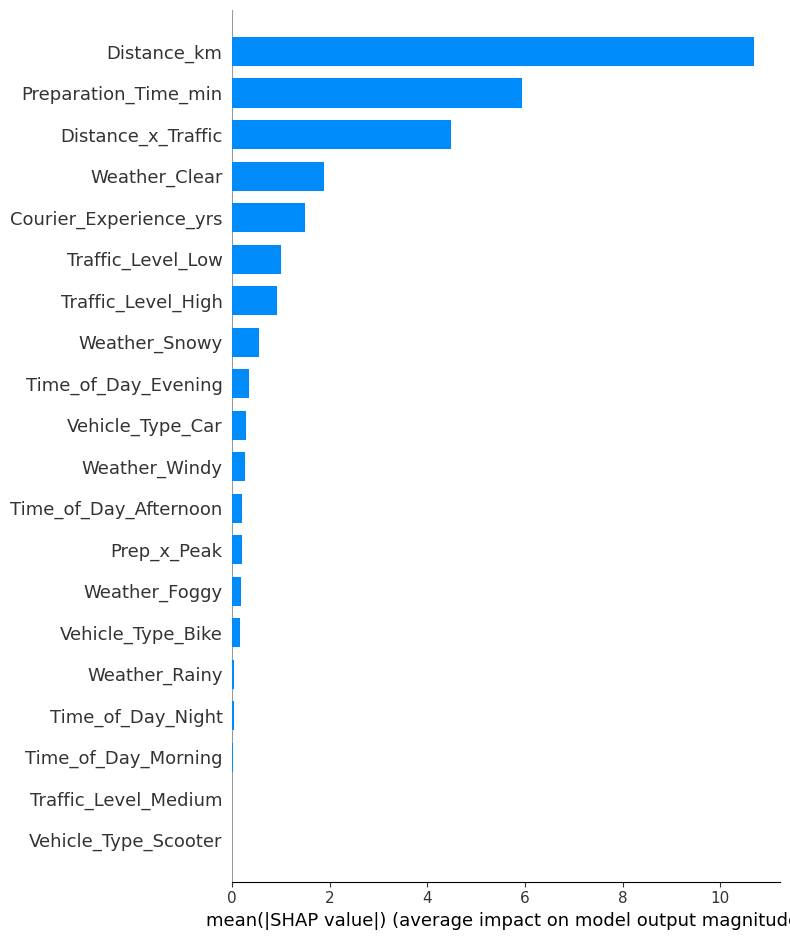

In [47]:
shap.summary_plot(shap_values, X_test_base, plot_type="bar")

**Interpretasi SHAP**

- **Distance_km & Distance_x_Traffic memberi kontribusi terbesar ;** jarak jauh dan kemacetan menaikkan prediksi secara signifikan.
- **Preparation_Time_min berdampak positif;** efeknya lebih kuat saat peak hour (Prep_x_Peak).
- **Traffic_Level_High** cenderung menaikkan prediksi dibanding traffic rendah/medium.
- **Cuaca buruk** (rainy, snowy, foggy, windy) menambah risiko secara kumulatif.
- **Courier_Experience_yrs sering berdampak negatif;**  pengalaman membantu menurunkan risiko/delay.
- **Fitur dengan SHAP ≈ 0 (Is_Peak_Hour, Vehicle_Type_Scooter)** tidak menambah informasi baru karena efeknya sudah tertangkap fitur lain atau interaksi.

## Partial Dependence Plot

In [48]:
features_to_plot = [
    "Distance_km",
    "Preparation_Time_min",
    "Weather_Clear"
]

C:\Users\MyBook Hype AMD\anaconda3\envs\Finalproject\Lib\site-packages\sklearn\inspection\_partial_dependence.py:717: FutureWarning: The column 1 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


<Figure size 1200x400 with 0 Axes>

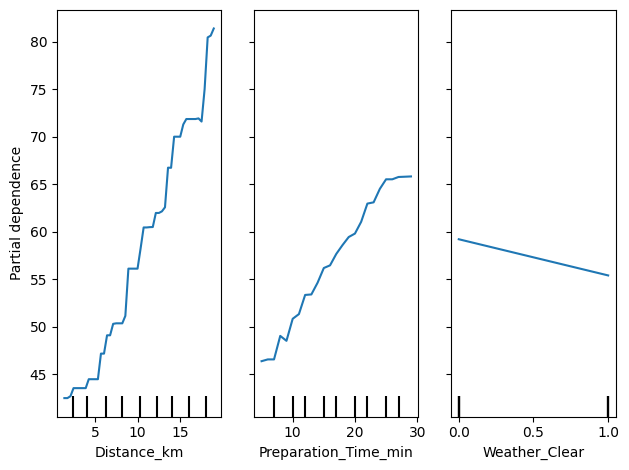

In [49]:
plt.figure(figsize=(12,4))

PartialDependenceDisplay.from_estimator(
    best_xgb,
    X_train_base,
    features=features_to_plot,
    kind="average",
    grid_resolution=50
)

plt.tight_layout()
plt.show()

**Interpretasi PDP:**

**Distance_km**

- Hubungan positif kuat dan non-linear.
- Semakin jauh jarak, prediksi meningkat tajam → jarak adalah driver utama.

**Preparation_Time_min**

- Hubungan positif konsisten.
- Waktu persiapan lebih lama langsung meningkatkan prediksi → indikasi bottleneck operasional.

**Weather_Clear**

- Hubungan negatif ringan.
- Kondisi cuaca cerah menurunkan prediksi dibanding cuaca buruk → cuaca buruk meningkatkan risiko/delay.

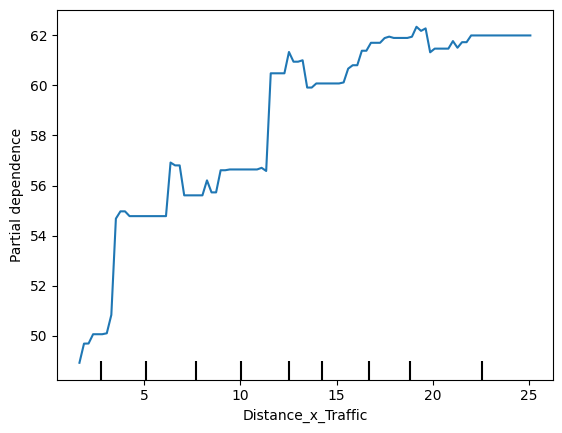

In [42]:
from sklearn.inspection import PartialDependenceDisplay


PartialDependenceDisplay.from_estimator(best_xgb, X_train_base, ['Distance_x_Traffic'])
plt.show()

**Interpretasi PDP – Distance_x_Traffic:**

**Hubungan positif kuat** ; semakin besar effective distance (jarak × kemacetan), prediksi semakin tinggi.

**Lonjakan tajam di nilai rendah–menengah** ; dampak kemacetan mulai terasa signifikan meskipun jarak belum terlalu jauh.

**Efek melandai di nilai tinggi** ; setelah ambang tertentu, tambahan jarak/kemacetan menaikkan prediksi secara lebih lambat (diminishing returns).

**Makna bisnis** ; kombinasi jarak dan kemacetan lebih krusial dibanding jarak saja; pengiriman jauh saat macet adalah risiko utama.

In [ ]:
import joblib

joblib.dump(best_xgb, "xgb_model.pkl")
joblib.dump(encoder, "encoder.pkl")
joblib.dump(num_cols.tolist(), "num_cols.pkl")
joblib.dump(cat_cols.tolist(), "cat_cols.pkl")
joblib.dump(X_train_base.columns.tolist(), "feature_order.pkl")
joblib.dump(num_medians, "num_medians.pkl")
joblib.dump(cat_modes, "cat_modes.pkl")